# Random Walk on Random Clusters

Here we consider the random walk on a 2D square lattice with randomly blocked sites. This is an interesting problem for two reasons: first, the structure of clusters of sites that are left accessible can be studied -- this is the "static" percolation problem, to figure out when we will find clusters that span the whole box, depending on the probability of individual sites to be blocked. Second, the "dynamic" problem of diffusion in that accessible structure can be studied.

In [2]:
import numpy as np
import operator as op
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import itertools
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
from numba import jit # to speed things up optionally
import numba as nb

Generation of lattices with randomly blocked sites is innocent enough: store the lattice as a matrix, walk through all matrix positions and for each mark the site accessible with probability $p$, blocked with probability $1-p$. (Python's numpy.vectorize is much faster than a for loop.)

The way we store the matrix is as follows: an entry zero indicates that the site is blocked, and an entry larger than zero is a label for an accessible site. To begin with, all labels are 1, but later on we will identify separate clusters of accessible sites, for which we will assign distinct labels beginning with 2.

In [4]:
def generate_matrix (dimensions,p):
    w,h = dimensions
    return (np.vectorize(lambda x: int(x<p))(np.random.random((w,h))))

We create little helper functions to visualize the matrices. We plot accessible sites in blue, inaccessible sites in transparent (white bg). For later use we will also implement creation of colormaps according to the size of individual clusters (in different gray scale), singling out a specific percolating cluster in blue. The visualization method also allows to show the matrix along with a specified set of its x-periodic and y-periodic images (but at the moment that is not used).

In [5]:
def cluster_colormap (label=1,clustersizes=None):
    # generate a colormap that assigns to each label index in clustersizes a gray scale according to
    # the indicated size; and blue color to the specified label argument
    if not clustersizes is None:
        nonpercsize = max(clustersizes)
        cmap = [tuple([0.3*float(clustersizes[x])/nonpercsize+0.4 for rgb in range(3)])
                for x in range(len(clustersizes)) ]
        cmap[0] = [1.,1.,1.,0] # transparent
    else:
        cmap = [[1.,1.,1.,0] for x in range(label+1)]
    if label>0:
        cmap[label]='b'
    return matplotlib.colors.ListedColormap(cmap)
def visualize_matrix (mat,periodic_images=([0],[0]),cmap=cluster_colormap()):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_aspect(1)
    xcopies,ycopies = periodic_images
    w,h = mat.shape[:]
    xm,ym = np.meshgrid(np.arange(0,w+1,1)-.5,np.arange(0,h+1,1)-.5)
    for x in xcopies:
        for y in ycopies:
            plt.pcolormesh(xm+x*(len(xm)-1),ym+y*(len(ym)-1),mat.T,cmap=cmap)
    plt.show()

Here is a typical randomly blocked matrix:

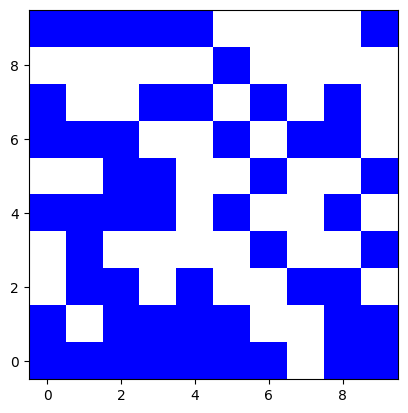

In [6]:
width0 = 10
height0 = 10
p0 = 0.5
mat0 = generate_matrix((width0,height0),p0)
visualize_matrix (mat0)

In [7]:
width1 = 200
height1 = 200
p1 = 0.595
mat1 = generate_matrix((width1,height1),p1)

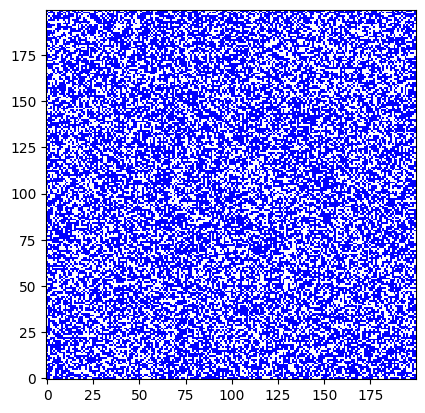

In [8]:
visualize_matrix (mat1)

## Blind and Myopic Ants

Given a matrix, a random walk is easily generated: we pick a starting position (possibly adjusting it randomly until we have a starting position that is on the correctly labeled portion of the matrix), and then take random steps, restricting the movement of the walker to sites with the same label as the one we started on.

Since the matrix is of finite size, we introduce periodic boundary conditions (through the method pbcrwap that does it for one dimension, and pbcwrap2 that does it for the 2d tuple). Of course in the end one will have to check for finite-size effects because the periodic boundary conditions impose an artificial periodicity in the random lattice.

For choosing the walker's next step, there are two possibilities, denoted by de Gennes as the "blind ant" and the "mypoic ant". The "blind ant" chooses one of the four neighboring sites of the full 2D lattice at random, and goes there if that site is accessible. If that site is blocked, the bilnd ant stays put but still counts that as another step.

In [9]:
direction_list = [ [1,0], [0,1], [-1,0], [0,-1] ]
@jit
def accu_prob (stepweights):
    #prob = np.array(list(stepweights))
    #prob = np.add.accumulate (prob/sum(prob))
    prob = np.cumsum(stepweights)
    return (prob/np.sum(prob))
#@jit
def pbcwrap (i, w):
    return (i%w)
#@jit
def pbcwrap2 (ij,wh):
    return tuple([pbcwrap(ij[d],wh[d]) for d in range(len(ij))])
    #return tuple([pbcwrap(ij[d],wh[d]) for d in range(len(ij))])
#@jit(nopython=True)
def blind_ant (N, mat, label=1, startpos=[0,0]):
    directions = np.array(direction_list)
    #directions = list(map(np.array,direction_list))
    #prob = accu_prob (map(lambda x:1,direction_list))
    prob = accu_prob (np.ones(len(directions)))
    dim = mat.shape[:]
    walkpos = np.array(startpos)
    # adjust starting position until it lies on an accessible site
    while (mat[pbcwrap2(walkpos,dim)]!=label):
        walkpos = walkpos + directions[np.random.choice(len(directions))]
    walk = []
    walk.append (walkpos)
    for i in range(N):
        # at each step, pick a direction at random, according to the assigned probabilities
        # in the array prob, we store the accumulated probabilities, so that we can also introduce
        # a bias for the walker to prefer specific directions, if so desired
        choice = np.random.random()
        for d in range(len(prob)):
            if (choice < prob[d]):
                # blind ant: pick a random direction, and accept it if accessible, discard else
                newwalkpos = walkpos + directions[d]
                if (mat[pbcwrap2(newwalkpos,dim)]==label):
                    walkpos = newwalkpos
                break
        walk.append (walkpos)
    return np.array(walk)

The "myopic ant" first looks at all the neighboring sites and assigns zero probability to the sites that are inaccessible. This way, the walker always moves.

In [10]:
#@jit(nopython=True)
def myopic_ant (N, mat, label=1, startpos=[0,0]):
    directions = np.array(direction_list)
    prob = np.array(list(map(lambda x:1,direction_list)))
    dim = mat.shape[:]
    walkpos = np.array(startpos)
    # adjust starting position
    while (mat[pbcwrap2(walkpos,dim)]!=label):
        walkpos = walkpos + directions[np.random.choice(len(directions))]
    walk = []
    walk.append (walkpos)
    for i in range(N):
        # myopic ant: calculate stepping probabilities, discarding sites that are inaccessible right away
        myopic_prob = np.copy(prob)
        for d in range(len(prob)):
            if mat[pbcwrap2(walkpos+directions[d],dim)]!=label:
                myopic_prob[d] = 0
        myopic_prob = accu_prob (myopic_prob)
        choice = np.random.random()
        for d in range(len(myopic_prob)):
            if (choice < myopic_prob[d]):
                walkpos = walkpos + directions[d]
                assert mat[pbcwrap2(walkpos,dim)]==label
                break
        walk.append (walkpos)
    return np.array(walk)

Let us make a few test runs to see how the two modes of stepping compare to each other.

In [47]:
walk1 = blind_ant (20000,generate_matrix((width1,height1),p1))

In [48]:
walk2 = myopic_ant (20000,generate_matrix((width1,height1),p1))

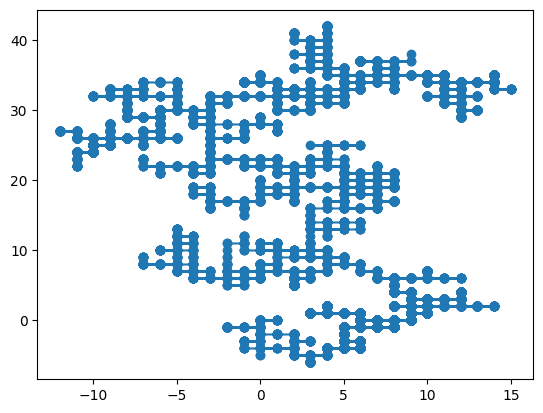

In [49]:
plt.figure()
plt.plot(walk1[:,0],walk1[:,1],'-o')
plt.show()

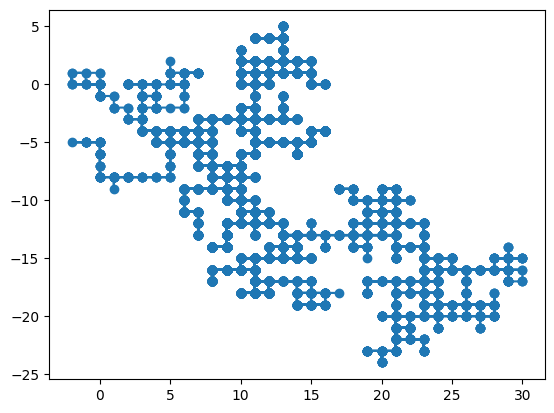

In [50]:
plt.figure()
plt.plot(walk2[:,0],walk2[:,1],'-o')
plt.show()

To quantify this, let us look at the mean-squared displacements (MSD) calculated from those trial runs.

In order to improve the statistics, we make use of the fact that the process as defined is stationary. This means that in calculating the MSD, we can use several positions along the individual trajectory as starting points, and average also over starting points. This is encoded in the following helper function. (It expects as its argument an array of trajectories, because later we will also need to average over several realizations of trajectories, also for different realizations of the random matrix.)

In [57]:
@jit
def genmsd(walklist,step=1):
    shifts = np.arange(0,len(walklist[0])//10,step)
    msds = np.zeros((len(walklist),len(shifts)))
    avgmsd = np.zeros(len(shifts))
    for i,walk in enumerate(walklist):
        for j,dt in enumerate(shifts):
            diffs = walk[:len(walk)-dt] - walk[dt:]
            msds[i,j] += np.square(diffs).sum(axis=1).mean()
    for i,dt in enumerate(shifts):
        avgmsd[i] = msds[:,i].mean()
    return shifts,avgmsd

In [58]:
tstt1,tstmsd1 = genmsd([walk1],step=10)

In [59]:
tstt2,tstmsd2 = genmsd([walk2],step=10)

Here we compare the two MSD with the expectation from ordinary diffusion (black dotted line). As intuitively expected, the MSD grows slower on the randomly blocked lattice than on the free lattice. After a short transient, it also appears that both the blind and the myopic ant give the same results for the MSD up to a rescaling of the time step.

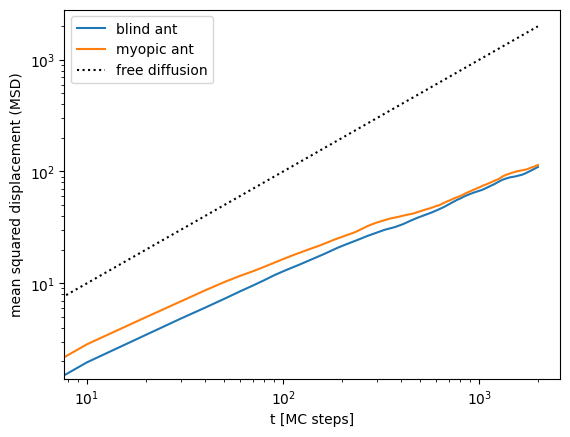

In [60]:
plt.figure()
plt.loglog(tstt1,tstmsd1,label='blind ant')
plt.loglog(tstt2,tstmsd2,label='myopic ant')
plt.loglog(tstt1,tstt1,ls='dotted',c='black',label='free diffusion')
plt.xlabel('t [MC steps]')
plt.ylabel('mean squared displacement (MSD)')
plt.legend()
plt.show()

## Percolation of Clusters

Let us turn back to the problem of static percolation. It seems intuitively evident that for small probability $p$ to make sites accessible, these appear as independent small clusters that do not span the whole box. But for large $p$, the probability of finding clusters that percolate should increase. In the infinite system, one indeed expects a sharp crossover at some $p_c$, such that for $p<p_c$ the probability to find a percolating cluster is zero, and above it is one.

In order to talk about clusters in the first place, we need an algorithm that identifies them. The following is an implementation of a rather famous algorithm, due to Hoshen-Kopelman. The algorithm roughly goes as this: we walk through the matrix starting in the upper left corner. At each point, we check whether the site above or left is accessible, and if so, we assign the current site the same label as this one. If both are accessible, we make a note that their two labels are linked through the present site, and if none are accessible we start a new label. Walking through the matrix thus builds and equivalence class of labels telling us which parts of the matrix are linked through nearest neighbors.

After one walk-through, we check whether labels are linked through opposite boundaries of the box, and those are the clusters that percolate. There is some issue with clusters that might percolate diagonally across several box boundaries, and at the moment we do not catch them. The point here is not to go into a deep discussion of the algorithm, but just to provide a boxed method that identifies the clusters and whether there is a percolating one.

In [61]:
@jit(nopython=True)
def find_clusters (mat):
    num_occupied = sum(mat.reshape(-1))
    w,h = mat.shape[:]
    labels = np.arange(w*h)
    def same_as (l):
        while (labels[l]) != l:
            l = labels[l]
        return l
    def link (label1,label2):
        labels[same_as(label1)] = same_as(label2)
    label = 1
    for i in range(w):
        for j in range(h):
            if mat[i,j]>0:
                left = mat[i-1,j] if (i>0) else 0
                above = mat[i,j-1] if (j>0) else 0
                if (left<=1 and above<=1):
                    label += 1
                    mat[i,j] = label
                elif (left>1 and above<=1):
                    mat[i,j] = same_as(left)
                elif (left<=1 and above>1):
                    mat[i,j] = same_as(above)
                else:
                    link(left,above)
                    mat[i,j] = same_as(left)
    labels_tmp = np.copy(labels)
    def same_as_tmp (l):
        while (labels_tmp[l]) != l:
            l = labels_tmp[l]
        return l
    def link_tmp (label1,label2):
        labels_tmp[same_as_tmp(label1)] = same_as_tmp(label2)
    percolates = np.zeros(label+1,dtype=np.int32)
    loopstarts = np.zeros(label+1,dtype=np.int32)
    looplist = []
    for j in range(h):
        if mat[w-1,j]>1 and mat[0,j]>1:
            l1 = mat[0,j]
            l2 = mat[w-1,j]
            link_tmp (l1,l2)
            if same_as(l1)==same_as(l2):
                percolates[same_as(l1)]=1
            else:
                1
                #looplist
    for i in range(w):
        if mat[i,h-1]>1 and mat[i,0]>1:
            l1 = mat[i,0]
            l2 = mat[i,h-1]
            link_tmp (l1,l2)
            if same_as(l1)==same_as(l2):
                percolates[same_as(l1)]=1
            else:
                1
                #looplist
    if sum(percolates):
        1
        # found percolating cluster
    else:
        1
        # check looplist for diagonal percolation
    labels = np.copy(labels_tmp)
    #
    maxl = 0
    for i in range(w):
        for j in range(h):
            l = same_as(mat[i,j])
            mat[i,j] = l
            if (l>maxl):
                maxl = l
    size = np.zeros(maxl+1,dtype=np.int32)
    for i in range(w):
        for j in range(h):
            size[mat[i,j]] += 1
    percl = 0
    percsize = 0
    for l in range(1,len(percolates)):
        if percolates[l]:
            ll = same_as(l)
            if (size[ll]>percsize):
                percsize = size[ll]
                percl = ll
    return mat,percl,size

To demonstrate it for the test matrix above, here is a plot where the individual clusters are shaded in grey (darkness according to their size), and the percolating cluster (if present) is colored in blue.

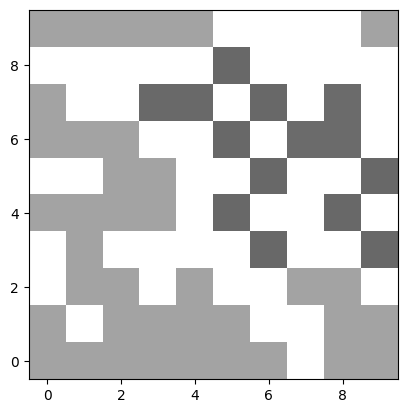

In [62]:
mat0,percl,sizes = find_clusters (mat0)
visualize_matrix (mat0,cmap=cluster_colormap(percl,sizes))

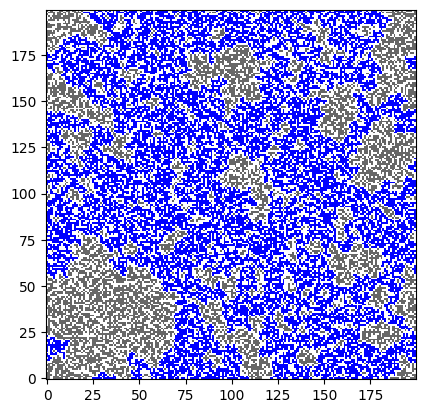

In [63]:
mat1,percl,sizes = find_clusters (mat1)
visualize_matrix (mat1,cmap=cluster_colormap(percl,sizes))

Now we move to a more quantitative analysis of the percolation problem: Let us generate some matrices for any fixed $p$, figure out whether there is a percolating cluster. We repeat a number of times and aim to plot the relative number of instances where we found a percolating cluster. As outlined above, in the limit of infinitely large boxes, this quantity is expected to become a setup function. The proper way to estimate the percolation point with finite-size matrices, is to do finite-size scaling: we repeat the exercise for different box lengths, and we should get increasingly sharp sigmoidal curves whose inflection point, at large enough box lengths, is at the percolation threshold $p_c$.

In [64]:
def find_percsizes(L1,Nmat=1000,plist = [0.55,0.57,0.58,0.59,0.592,0.594,0.6,0.61,0.62,0.65]):
    percsizes = np.zeros(len(plist))
    percprobs = np.zeros(len(plist))
    for pi,p in enumerate(plist):
        percsize = 0
        percprob = 0
        for n in range(Nmat):
            mat,percl,size = find_clusters (generate_matrix((L1,L1),p))
            if percl>0:
                percsize = percsize + size[percl]
                percprob += 1
        percsizes[pi] = percsize / Nmat
        percprobs[pi] = percprob / Nmat
    return (plist,percsizes,percprobs)

We try for some box lenghts $L$, and over a $p$-interval that is already adapted to the result that is expected. These runs are costly! Recall that the cluster-find algorithm needs to walk through all the sites, so it scales as $\mathcal O(L^2)$. It's a lot of matrices that we need to consider as well, and what is done here is only just a really rough sketch of a proper calculation.

In [65]:
ppr = []
psz = []
Lrange = [50,100]
for L1 in Lrange:
    plist,percsizes,percprobs = find_percsizes(L1)
    ppr.append(percprobs)
    psz.append(percsizes)

Here is a plot of the percolation probability as a function of $p$. Indeed, we see sigmoidal shapes. Fits with a simple-minded $(\tanh((p-p_c)/w)+1)/2$ allows to estimate $p_c$. Actually, the results are already not too bad: the accepted $p_c$ for the square lattice in 2D is $p_c\approx0.592746$.

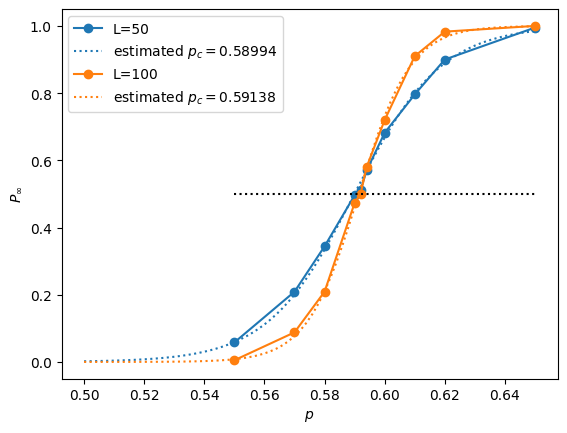

In [66]:
plt.figure()
def tanh_law (p,pc,width):
    return 0.5*(1+np.tanh((p-pc)/width))
colorcycle = itertools.cycle(colorlist)
for i,L1 in enumerate(Lrange):
    color=next(colorcycle)
    plt.plot (plist,ppr[i],'-o',label='L={}'.format(L1),color=color)
    popt,pcov = scipy.optimize.curve_fit (tanh_law,plist,ppr[i])
    plt.plot (np.arange(0.5,0.65,0.002),tanh_law(np.arange(0.5,0.65,0.002),popt[0],popt[1]),ls='dotted',color=color,
             label='estimated $p_c={:.5f}$'.format(popt[0]))
plt.plot(plist,np.ones(len(plist))*0.5,c='black',ls='dotted')
plt.xlabel(r'$p$')
plt.ylabel(r'$P_\infty$')
plt.legend()
plt.show()

In [67]:
pc = 0.592746

We can easily also test one other prediction of the critical-scaling theory of percolation: close to $p_c$, one expects the size of the percolating cluster to increase with a power law, $P_\infty\sim|p-p_c|^\beta$, where $\beta$ is one of the critical exponents of the model. For percolation on a 2D lattice, $\beta=5/36$ should hold. We obviously have too strong finite-size effects for that, still.

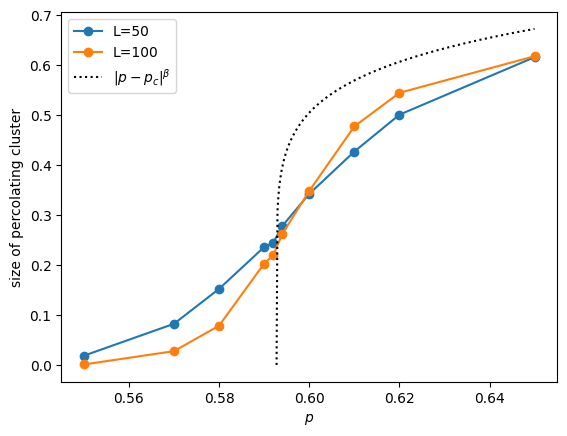

In [68]:
plt.figure()
colorcycle = itertools.cycle(colorlist)
for i,L1 in enumerate(Lrange):
    color = next(colorcycle)
    plt.plot(plist,psz[i]/L1/L1,'-o',label='L={}'.format(L1),color=color)
plt.plot (np.arange(pc,0.65,0.0002),np.power(np.abs(np.arange(pc,0.65,0.0002)-pc),5./36),ls='dotted',color='black',label=r'$|p-p_c|^\beta$')
plt.xlabel(r'$p$')
plt.ylabel(r'size of percolating cluster')
plt.legend()
plt.show()

## Diffusion on the Percolating Cluster

Now, we turn to the question of random-walk motion on the cluster again. In fact, in order to get long-range transport, the random walk should be studied on the percolating cluster. In this case, scaling theory suggests that $$\delta r^2\sim t^{2/d_w}$$ where $d_w$ is the *walk dimension* and represents a critical exponent that is new, in the sense that it is not determined by any combination of the exponents that characterize the static percolation problem alone.

The appearance of a long-time power-law asymptote in the MSD is termed *anomalous diffusion*. Hence, the random walk on the percolating cluster shows anomalous diffusion. For $p\neq p_c$, this cannot be the true long-time asymptote, but we expect that close enough to $p_c$, we will have an increasing time window where the anomalous diffusion law holds. At longer times, the MSD will either become diffusive for $p>p_c$, or show a plateau signalling trapped particles for $p<p_c$. You should find it easy to play around, just by changing the number given to the command that generates the walks. (We also focus on the blind ant here, as it is the slightly easier code; you can check that results will be qualitatively the same for the myopic ant.)

We also compare the anomalous-diffusion law with the MSD that is obtained if we just place the walker randomly on an accessible site, not checking whether it is on a percolating cluster or not (as we did further above). The MSD thus obtained will get contributions from trapped walkers and hence is expected to grow slower than the one on the percolating cluster alone. Since clusters come in all sizes (there is no intrinsic scale for them), the expectation is a modified power law, $$\delta r^2\sim t^{2/z}$$ with a dynamical exponent $z$ that fulfills $z>d_w$.

In the plot, we compare with the accepted "correct" values for the 2D square lattice: $d_w\approx2.878$ and $z\approx3.036$.

In [89]:
walklist = list(map(lambda n:blind_ant (10000,generate_matrix((width1,height1),pc)),range(100)))

In [90]:
percl=0
while percl==0:
    mat = generate_matrix((width1,height1),pc)
    mat,percl,sizes = find_clusters (mat)
walklist2 = list(map(lambda n:blind_ant (10000,mat,label=percl),range(100)))

In [91]:
tr,msd=genmsd(walklist,step=10)

In [92]:
tr2,msd2=genmsd(walklist2,step=10)

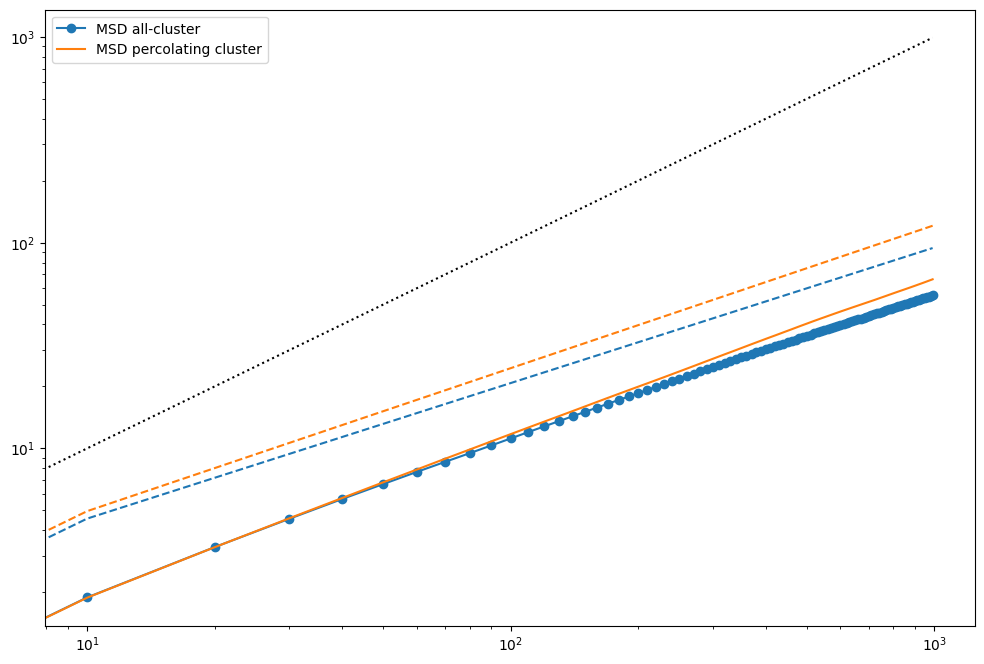

In [93]:
plt.figure(figsize=(12,8))
colorcycle = itertools.cycle(colorlist)
color = next(colorcycle)
plt.loglog (tr,msd,'o-',label='MSD all-cluster',color=color)
plt.loglog (tr,np.power(tr,2/3.036),ls='dashed',color=color)
color = next(colorcycle)
plt.loglog (tr2,msd2,label='MSD percolating cluster',color=color)
plt.loglog (tr2,np.power(tr2,2/2.878),ls='dashed',color=color)
plt.loglog (tr,np.power(tr,1),ls='dotted',c='black')
#plt.xlim(1,10000)
plt.legend()
plt.show()

Actually a more proper way to check for expected power laws is to divide the numerical results by them and check whether the data transformed in this way approaches a constant at long times:

/tmp/ipykernel_1616163/4074112760.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(tr,msd/np.power(tr,2/3.036))
/tmp/ipykernel_1616163/4074112760.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(tr2,msd2/np.power(tr2,2/2.878))


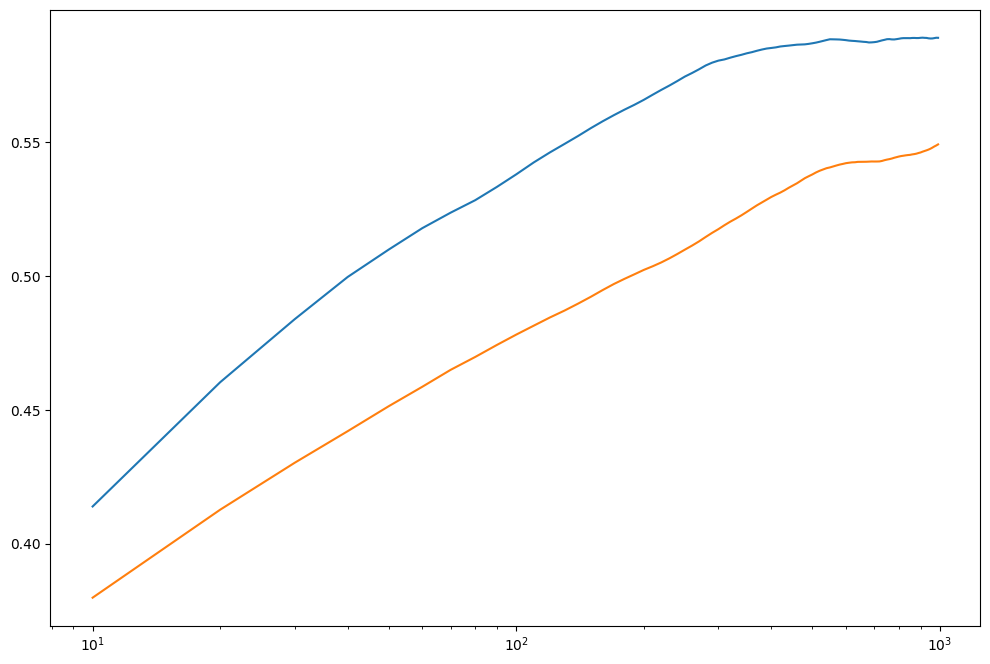

In [94]:
plt.figure(figsize=(12,8))
plt.plot(tr,msd/np.power(tr,2/3.036))
plt.plot(tr2,msd2/np.power(tr2,2/2.878))
plt.xscale('log')
plt.show()